#Obtenção de dataset e reamostragem para 16KHz

In [ ]:
import os
import librosa
import soundfile as sf
import pandas as pd
import kagglehub
from tqdm.auto import tqdm
import warnings

# Ignorar avisos do Librosa para uma saída mais limpa
warnings.filterwarnings('ignore')


# ------------------------------------------------------------------------------
# DEFINIÇÃO DAS FUNÇÕES
# ------------------------------------------------------------------------------

def analyze_audio_dataset(dataset_path, dataset_name):
    """Analisa um diretório de áudios e extrai métricas chave."""
    audio_files = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.wav', '.mp3', '.flac', '.ogg', '.m4a')):
                audio_files.append(os.path.join(root, file))
    if not audio_files: return {"Dataset": dataset_name, "Total de Arquivos": 0}

    durations, sample_rates, file_sizes_bytes, formats = [], [], [], set()

    print(f"Analisando '{dataset_name}'...")
    for file_path in tqdm(audio_files, desc=f"Processando {dataset_name}", unit="arq"):
        try:
            file_sizes_bytes.append(os.path.getsize(file_path))
            formats.add(os.path.splitext(file_path)[1].lower())
            y, sr = librosa.load(file_path, sr=None)
            durations.append(librosa.get_duration(y=y, sr=sr))
            sample_rates.append(sr)
        except Exception as e:
            print(f"Erro ao processar {os.path.basename(file_path)}: {e}")

    class_counts = {}
    for item in os.listdir(dataset_path):
        item_path = os.path.join(dataset_path, item)
        if os.path.isdir(item_path):
            count = len([f for f in os.listdir(item_path) if f.lower().endswith(('.wav', '.mp3', '.flac', '.ogg', '.m4a'))])
            if count > 0: class_counts[item] = count

    return {
        "Dataset": dataset_name, "Total de Arquivos": len(audio_files),
        "Formatos": ", ".join(sorted(list(formats))),
        "Taxas de Amostragem (Hz)": ", ".join(map(str, sorted(pd.Series(sample_rates).unique()))),
        "Duração Total (min)": f"{(sum(durations) / 60):.2f}",
        "Duração Média (s)": f"{pd.Series(durations).mean():.2f}",
        "Tamanho Total (GB)": f"{(sum(file_sizes_bytes) / (1024**3)):.2f}",
        "Tamanho Médio (MB)": f"{(pd.Series(file_sizes_bytes).mean() / (1024**2)):.2f}",
        "Distribuição de Classes": class_counts if class_counts else "N/A"
    }

def resample_and_save_dataset(original_path, output_path, target_sr):
    """Reamostra um dataset de áudio para a target_sr e salva no destino."""
    print(f"\nIniciando reamostragem para {target_sr} Hz. Destino: {output_path}")
    audio_files_to_process = []
    for root, _, files in os.walk(original_path):
        for file in files:
            if file.lower().endswith(('.wav', '.mp3', '.flac', '.ogg', '.m4a')):
                audio_files_to_process.append(os.path.join(root, file))

    for original_filepath in tqdm(audio_files_to_process, desc="Reamostrando arquivos"):
        try:
            y, sr = librosa.load(original_filepath, sr=target_sr)
            relative_path = os.path.relpath(os.path.dirname(original_filepath), original_path)
            output_dir = os.path.join(output_path, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            filename_wav = os.path.splitext(os.path.basename(original_filepath))[0] + '.wav'
            output_filepath = os.path.join(output_dir, filename_wav)
            sf.write(output_filepath, y, target_sr)
        except Exception as e:
            print(f"Erro ao reamostrar {os.path.basename(original_filepath)}: {e}")
    print("Reamostragem concluída.")


# ------------------------------------------------------------------------------
# DOWNLOAD E REAMOSTRAGEM
# ------------------------------------------------------------------------------

print("Baixando datasets do Kaggle...")
noise_audio_path = kagglehub.dataset_download("javohirtoshqorgonov/noise-audio-data")
anuran_path = kagglehub.dataset_download("mehmetbayin/anuran-sound-frogs-or-toads-dataset")
print("Download concluído.")

TARGET_SR = 16000
RESAMPLED_BASE_PATH = "/kaggle/working/resampled_audio"
noise_output_path = os.path.join(RESAMPLED_BASE_PATH, "noise_audio_16khz")
anuran_output_path = os.path.join(RESAMPLED_BASE_PATH, "anuran_audio_16khz")

resample_and_save_dataset(noise_audio_path, noise_output_path, TARGET_SR)
resample_and_save_dataset(anuran_path, anuran_output_path, TARGET_SR)


# ------------------------------------------------------------------------------
# ANÁLISE FINAL COM OS DATASETS PRONTOS (16 kHz)
# ------------------------------------------------------------------------------

print("\n--- Analisando Datasets Prontos para o Modelo (16 kHz) ---")

final_datasets_to_analyze = [
    {"name": "Noise Audio (16kHz)", "path": noise_output_path},
    {"name": "Anuran Sound (16kHz)", "path": anuran_output_path},
]

all_final_summaries = []
for dataset in final_datasets_to_analyze:
    summary_dict = analyze_audio_dataset(dataset["path"], dataset["name"])
    all_final_summaries.append(summary_dict)
    print("-" * 50)

final_summary_df = pd.DataFrame(all_final_summaries).dropna(axis=1, how='all')
final_summary_df.set_index("Dataset", inplace=True)

print("\n--- Sumário dos Datasets Prontos para o Modelo (16 kHz) ---")
display(final_summary_df)

Baixando datasets do Kaggle...
Download concluído.

Iniciando reamostragem para 16000 Hz. Destino: /kaggle/working/resampled_audio/noise_audio_16khz


Reamostrando arquivos:   0%|          | 0/2000 [00:00<?, ?it/s]

Reamostragem concluída.

Iniciando reamostragem para 16000 Hz. Destino: /kaggle/working/resampled_audio/anuran_audio_16khz


Reamostrando arquivos:   0%|          | 0/1536 [00:00<?, ?it/s]

Reamostragem concluída.

--- Analisando Datasets Prontos para o Modelo (16 kHz) ---
Analisando 'Noise Audio (16kHz)'...


Processando Noise Audio (16kHz):   0%|          | 0/2000 [00:00<?, ?arq/s]

--------------------------------------------------
Analisando 'Anuran Sound (16kHz)'...


Processando Anuran Sound (16kHz):   0%|          | 0/1536 [00:00<?, ?arq/s]

--------------------------------------------------

--- Sumário dos Datasets Prontos para o Modelo (16 kHz) ---


Total de Arquivos Formatos Taxas de Amostragem (Hz)  \
Dataset                                                                     
Noise Audio (16kHz)                2000     .wav                    16000   
Anuran Sound (16kHz)               1536     .wav                    16000   

                     Duração Total (min) Duração Média (s) Tamanho Total (GB)  \
Dataset                                                                         
Noise Audio (16kHz)               166.67              5.00               0.30   
Anuran Sound (16kHz)               68.38              2.67               0.12   

                     Tamanho Médio (MB) Distribuição de Classes  
Dataset                                                          
Noise Audio (16kHz)                0.15                     N/A  
Anuran Sound (16kHz)               0.08                     N/A

# Reprodução de Amostras

In [ ]:
import os
import random
from IPython.display import Audio, display

print("\n\n--- Preparando Amostras de Áudio dos Datasets Finais (16kHz) ---")
final_datasets_audio = [
    {"name": "Noise Audio (16kHz)", "path": noise_output_path},
    {"name": "Anuran Sound (16kHz)", "path": anuran_output_path},
]
for dataset in final_datasets_audio:
    print(f"\n\n--- Amostra de: {dataset['name']} ---")
    all_audio_files = []
    for root, _, files in os.walk(dataset['path']):
        for file in files:
            if file.lower().endswith('.wav'):
                all_audio_files.append(os.path.join(root, file))
    if all_audio_files:
        sample_file = random.choice(all_audio_files)
        print(f"Reproduzindo arquivo: {os.path.basename(sample_file)}")
        display(Audio(sample_file))
    else:
        print("Nenhum arquivo de áudio de amostra (.wav) foi encontrado.")



--- Preparando Amostras de Áudio dos Datasets Finais (16kHz) ---


--- Amostra de: Noise Audio (16kHz) ---
Reproduzindo arquivo: 2-101676-A-10.wav




--- Amostra de: Anuran Sound (16kHz) ---
Reproduzindo arquivo: 11 (9).wav


#Seleção de Classes

## Renomeando áudios da fonte noises

In [ ]:
import pandas as pd

csv_file_path = '/kaggle/input/noise-audio-data/ESC-50-master/meta/esc50.csv'

try:
    df = pd.read_csv(csv_file_path)
    print("DataFrame com as colunas 'filename', 'category' e 'target':")
    print(df[['filename', 'category', 'target']].head())

    print("\nInformações sobre as categorias e targets:")
    print(df[['category', 'target']].info())

    print("\nContagem de valores únicos para 'category':")
    print(df['category'].value_counts())

except FileNotFoundError:
    print(f"Erro: O arquivo não foi encontrado no caminho especificado: {csv_file_path}")
except Exception as e:
    print(f"Ocorreu um erro ao carregar ou processar o arquivo: {e}")

DataFrame com as colunas 'filename', 'category' e 'target':
            filename        category  target
0   1-100032-A-0.wav             dog       0
1  1-100038-A-14.wav  chirping_birds      14
2  1-100210-A-36.wav  vacuum_cleaner      36
3  1-100210-B-36.wav  vacuum_cleaner      36
4  1-101296-A-19.wav    thunderstorm      19

Informações sobre as categorias e targets:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2000 non-null   object
 1   target    2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None

Contagem de valores únicos para 'category':
category
dog                 40
chirping_birds      40
vacuum_cleaner      40
thunderstorm        40
door_wood_knock     40
can_opening         40
crow                40
clapping            40
fireworks           40
chainsaw            40
airplane            40
mouse

In [ ]:
import pandas as pd
import os

csv_path = '/kaggle/input/noise-audio-data/ESC-50-master/meta/esc50.csv'
audio_dir = '/kaggle/working/resampled_audio/noise_audio_16khz/ESC-50-master/audio'

try:
    df_meta = pd.read_csv(csv_path)
    print(f"Metadata carregada com sucesso do arquivo: {csv_path}")
    print(f"Total de {len(df_meta)} entradas de áudio no CSV.")
except FileNotFoundError:
    print(f"ERRO: Arquivo CSV não encontrado em {csv_path}. Verifique o caminho.")
    exit()
except Exception as e:
    print(f"ERRO ao carregar o CSV: {e}")
    exit()

filename_to_category = {
    os.path.splitext(row['filename'])[0]: row['category']
    for index, row in df_meta.iterrows()
}
print("\nMapeamento de nome_base_do_arquivo (sem extensão) para category criado.")

if not os.path.exists(audio_dir):
    print(f"ERRO: Diretório de áudio não encontrado em {audio_dir}. Verifique o caminho.")
else:
    renamed_count = 0
    skipped_count = 0
    error_count = 0

    print(f"\nIniciando o processo de renomeação na pasta: {audio_dir}")
    print("--------------------------------------------------")

    # Lista todos os arquivos no diretório de áudio
    for old_full_filename in os.listdir(audio_dir):
        # Separa o nome base do arquivo e sua extensão original
        base_filename, original_extension = os.path.splitext(old_full_filename)

        if base_filename in filename_to_category:
            category = filename_to_category[base_filename]

            # O novo nome será 'category-nomeBaseDoAudio.extensaoOriginal'
            new_full_filename = f"{category}-{base_filename}{original_extension}"

            old_filepath = os.path.join(audio_dir, old_full_filename)
            new_filepath = os.path.join(audio_dir, new_full_filename)

            try:
                os.rename(old_filepath, new_filepath)
                print(f"Renomeado: '{old_full_filename}' para '{new_full_filename}'")
                renamed_count += 1
            except FileNotFoundError:
                print(f"AVISO: Arquivo '{old_full_filename}' não encontrado em {audio_dir}. Pulando.")
                skipped_count += 1
            except Exception as e:
                print(f"ERRO ao renomear '{old_full_filename}': {e}")
                error_count += 1
        else:
            print(f"INFO: Arquivo '{old_full_filename}' (base: '{base_filename}') não encontrado no CSV. Pulando.")
            skipped_count += 1

    print("--------------------------------------------------")
    print(f"\nProcesso de renomeação concluído.")
    print(f"Total de áudios renomeados: {renamed_count}")
    print(f"Total de áudios pulados (não encontrados ou não mapeados): {skipped_count}")
    print(f"Total de erros na renomeação: {error_count}")

Metadata carregada com sucesso do arquivo: /kaggle/input/noise-audio-data/ESC-50-master/meta/esc50.csv
Total de 2000 entradas de áudio no CSV.

Mapeamento de nome_base_do_arquivo (sem extensão) para category criado.

Iniciando o processo de renomeação na pasta: /kaggle/working/resampled_audio/noise_audio_16khz/ESC-50-master/audio
--------------------------------------------------
Renomeado: '4-167642-A-21.wav' para 'sneezing-4-167642-A-21.wav'
Renomeado: '5-244315-A-6.wav' para 'hen-5-244315-A-6.wav'
Renomeado: '2-173618-A-39.wav' para 'glass_breaking-2-173618-A-39.wav'
Renomeado: '3-182023-A-30.wav' para 'door_wood_knock-3-182023-A-30.wav'
Renomeado: '3-188390-A-6.wav' para 'hen-3-188390-A-6.wav'
Renomeado: '4-250869-B-2.wav' para 'pig-4-250869-B-2.wav'
Renomeado: '2-80313-A-28.wav' para 'snoring-2-80313-A-28.wav'
Renomeado: '5-237499-A-4.wav' para 'frog-5-237499-A-4.wav'
Renomeado: '2-134049-A-6.wav' para 'hen-2-134049-A-6.wav'
Renomeado: '5-235593-A-23.wav' para 'breathing-5-235593-

##Agrupamento, Cópia e Separação de classes de interesse

In [ ]:
import shutil

print("--- ETAPA 3: CRIANDO DATASET DE SONS AMBIENTAIS SELECIONADOS ---")

SOURCE_NOISE_DIR = "/kaggle/working/resampled_audio/noise_audio_16khz/ESC-50-master/audio"
AMBIENT_DEST_DIR = "/kaggle/working/resampled_audio/ambient_audio_16khz"

desired_categories = [
    "dog", "chirping_birds", "thunderstorm", "crow", "pouring_water",
    "water_drops", "wind", "footsteps", "rain", "insects", "laughing",
    "hen", "breathing", "pig", "rooster", "crickets"
]

os.makedirs(AMBIENT_DEST_DIR, exist_ok=True)
print(f"Diretório de destino criado em: {AMBIENT_DEST_DIR}")

all_source_files = os.listdir(SOURCE_NOISE_DIR)

copied_count = 0
print("\nIniciando filtragem e cópia dos arquivos...")
for filename in tqdm(all_source_files, desc="Copiando arquivos selecionados"):
    if filename.startswith(tuple(desired_categories)):
        source_path = os.path.join(SOURCE_NOISE_DIR, filename)
        dest_path = os.path.join(AMBIENT_DEST_DIR, filename)

        shutil.copy2(source_path, dest_path)
        copied_count += 1

print("\n--------------------------------------------------")
print("Processo de cópia concluído.")
print(f"Total de categorias selecionadas: {len(desired_categories)}")
print(f"Total de arquivos copiados para '{AMBIENT_DEST_DIR}': {copied_count}")
print("--------------------------------------------------")

--- ETAPA 3: CRIANDO DATASET DE SONS AMBIENTAIS SELECIONADOS ---
Diretório de destino criado em: /kaggle/working/resampled_audio/ambient_audio_16khz

Iniciando filtragem e cópia dos arquivos...


Copiando arquivos selecionados:   0%|          | 0/2000 [00:00<?, ?it/s]


--------------------------------------------------
Processo de cópia concluído.
Total de categorias selecionadas: 16
Total de arquivos copiados para '/kaggle/working/resampled_audio/ambient_audio_16khz': 640
--------------------------------------------------


In [ ]:
import os
import pandas as pd
import librosa
from tqdm.auto import tqdm
from IPython.display import display

print("--- ETAPA FINAL: CONFIGURANDO CAMINHOS PARA ANÁLISE ---")

FINAL_ANURAN_PATH = "/kaggle/working/resampled_audio/anuran_audio_16khz"
FINAL_AMBIENT_PATH = "/kaggle/working/resampled_audio/ambient_audio_16khz"

print(f"Analisando Anuran/Frogs em: {FINAL_ANURAN_PATH}")
print(f"Analisando Sons Ambientais em: {FINAL_AMBIENT_PATH}")
print("-" * 60)

# ------------------------------------------------------------------------------
# DEFINIÇÃO DA FUNÇÃO DE ANÁLISE
# ------------------------------------------------------------------------------

def analyze_dataset_folder_advanced(folder_path, dataset_name, treat_as_single_class=False):
    if not os.path.isdir(folder_path):
        print(f"AVISO: O diretório '{folder_path}' não foi encontrado. Retornando dados vazios.")
        return {}

    audio_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.wav')]
    if not audio_files: return {}

    durations, sample_rates, file_sizes_bytes, formats = [], [], [], set()
    category_counts = {}

    for filename in tqdm(audio_files, desc=f"Analisando {dataset_name}"):
        file_path = os.path.join(folder_path, filename)
        try:
            file_sizes_bytes.append(os.path.getsize(file_path))
            formats.add(os.path.splitext(filename)[1].lower())
            y, sr = librosa.load(file_path, sr=None)
            durations.append(librosa.get_duration(y=y, sr=sr))
            sample_rates.append(sr)
            if not treat_as_single_class:
                category = filename.split('-')[0]
                category_counts[category] = category_counts.get(category, 0) + 1
        except Exception as e: print(f"Erro ao processar {filename}: {e}")

    total_files = len(audio_files)
    if treat_as_single_class:
        category_counts = {dataset_name: total_files}

    return {
        "Total de Arquivos": total_files,
        "Formatos": ", ".join(sorted(list(formats))),
        "Taxas de Amostragem (Hz)": ", ".join(map(str, sorted(pd.Series(sample_rates).unique()))),
        "Duração Total (min)": f"{(sum(durations) / 60):.2f}",
        "Duração Média (s)": f"{pd.Series(durations).mean():.2f}",
        "Tamanho Total (GB)": f"{(sum(file_sizes_bytes) / (1024**3)):.2f}",
        "Tamanho Médio (MB)": f"{pd.Series(file_sizes_bytes).mean() / (1024**2):.2f}",
        "Distribuição de Classes": category_counts
    }


# ------------------------------------------------------------------------------
# ANÁLISE DOS DATASETS E GERAÇÃO DOS RELATÓRIOS
# ------------------------------------------------------------------------------
print("\n--- ETAPA 2: ANALISANDO OS DATASETS FINAIS ---")

anuran_summary = analyze_dataset_folder_advanced(FINAL_ANURAN_PATH, "Anuran & Frogs", treat_as_single_class=True)
if anuran_summary: anuran_summary['Dataset'] = "Anuran & Frogs"

ambient_summary = analyze_dataset_folder_advanced(FINAL_AMBIENT_PATH, "Sons Ambientais Selecionados", treat_as_single_class=False)
if ambient_summary: ambient_summary['Dataset'] = "Sons Ambientais Selecionados"

main_summary_list = []
if anuran_summary: main_summary_list.append(anuran_summary.copy())
if ambient_summary: main_summary_list.append(ambient_summary.copy())

if main_summary_list:
    ambient_distribution = ambient_summary.pop("Distribuição de Classes")
    anuran_summary.pop("Distribuição de Classes")

    main_df = pd.DataFrame(main_summary_list)
    main_df.set_index("Dataset", inplace=True)
    main_df = main_df[[
        "Total de Arquivos", "Formatos", "Taxas de Amostragem (Hz)",
        "Duração Total (min)", "Duração Média (s)",
        "Tamanho Total (GB)", "Tamanho Médio (MB)"
    ]]

    print("\n\n" + "="*80)
    print("--- SUMÁRIO GERAL DOS DATASETS ---")
    print("="*80)
    display(main_df)

if 'ambient_distribution' in locals() and ambient_distribution:
    dist_df = pd.DataFrame(
        list(ambient_distribution.items()),
        columns=['Categoria', 'Contagem de Áudios']
    ).sort_values(by='Contagem de Áudios', ascending=False).reset_index(drop=True)

    print("\n\n" + "="*80)
    print("--- DISTRIBUIÇÃO DE CLASSES (Dataset: Sons Ambientais Selecionados) ---")
    print("="*80)
    display(dist_df)
else:
    print("\nNão foi possível gerar os relatórios de análise.")

--- ETAPA FINAL: CONFIGURANDO CAMINHOS PARA ANÁLISE ---
Analisando Anuran/Frogs em: /kaggle/working/resampled_audio/anuran_audio_16khz
Analisando Sons Ambientais em: /kaggle/working/resampled_audio/ambient_audio_16khz
------------------------------------------------------------

--- ETAPA 2: ANALISANDO OS DATASETS FINAIS ---


Analisando Anuran & Frogs:   0%|          | 0/1536 [00:00<?, ?it/s]

Analisando Sons Ambientais Selecionados:   0%|          | 0/640 [00:00<?, ?it/s]



--- SUMÁRIO GERAL DOS DATASETS ---


Total de Arquivos Formatos  \
Dataset                                                    
Anuran & Frogs                             1536     .wav   
Sons Ambientais Selecionados                640     .wav   

                             Taxas de Amostragem (Hz) Duração Total (min)  \
Dataset                                                                     
Anuran & Frogs                                  16000               68.38   
Sons Ambientais Selecionados                    16000               53.33   

                             Duração Média (s) Tamanho Total (GB)  \
Dataset                                                             
Anuran & Frogs                            2.67               0.12   
Sons Ambientais Selecionados              5.00               0.10   

                             Tamanho Médio (MB)  
Dataset                                          
Anuran & Frogs                             0.08  
Sons Ambientais Selecionados               0.15



--- DISTRIBUIÇÃO DE CLASSES (Dataset: Sons Ambientais Selecionados) ---


Categoria  Contagem de Áudios
0             crow                  40
1              hen                  40
2     thunderstorm                  40
3              pig                  40
4      water_drops                  40
5          insects                  40
6          rooster                  40
7         laughing                  40
8    pouring_water                  40
9        breathing                  40
10       footsteps                  40
11  chirping_birds                  40
12             dog                  40
13            rain                  40
14        crickets                  40
15            wind                  40

#Seleção de Tamanhos de Amostras e Partes de interesse do Audio

## Aplicação do Isolation Forest Para Extração de Partes de Interesse dos Audios

--- ETAPA FINAL: DETECÇÃO DE ANOMALIAS E VISUALIZAÇÃO ---


Processando Dataset: Anuran & Frogs
Analisando 10 áudios de 'Anuran & Frogs'...


Processando áudios de Anuran & Frogs:   0%|          | 0/10 [00:00<?, ?it/s]


Treinando e aplicando Isolation Forest com base nos scores...
Gerando gráficos...


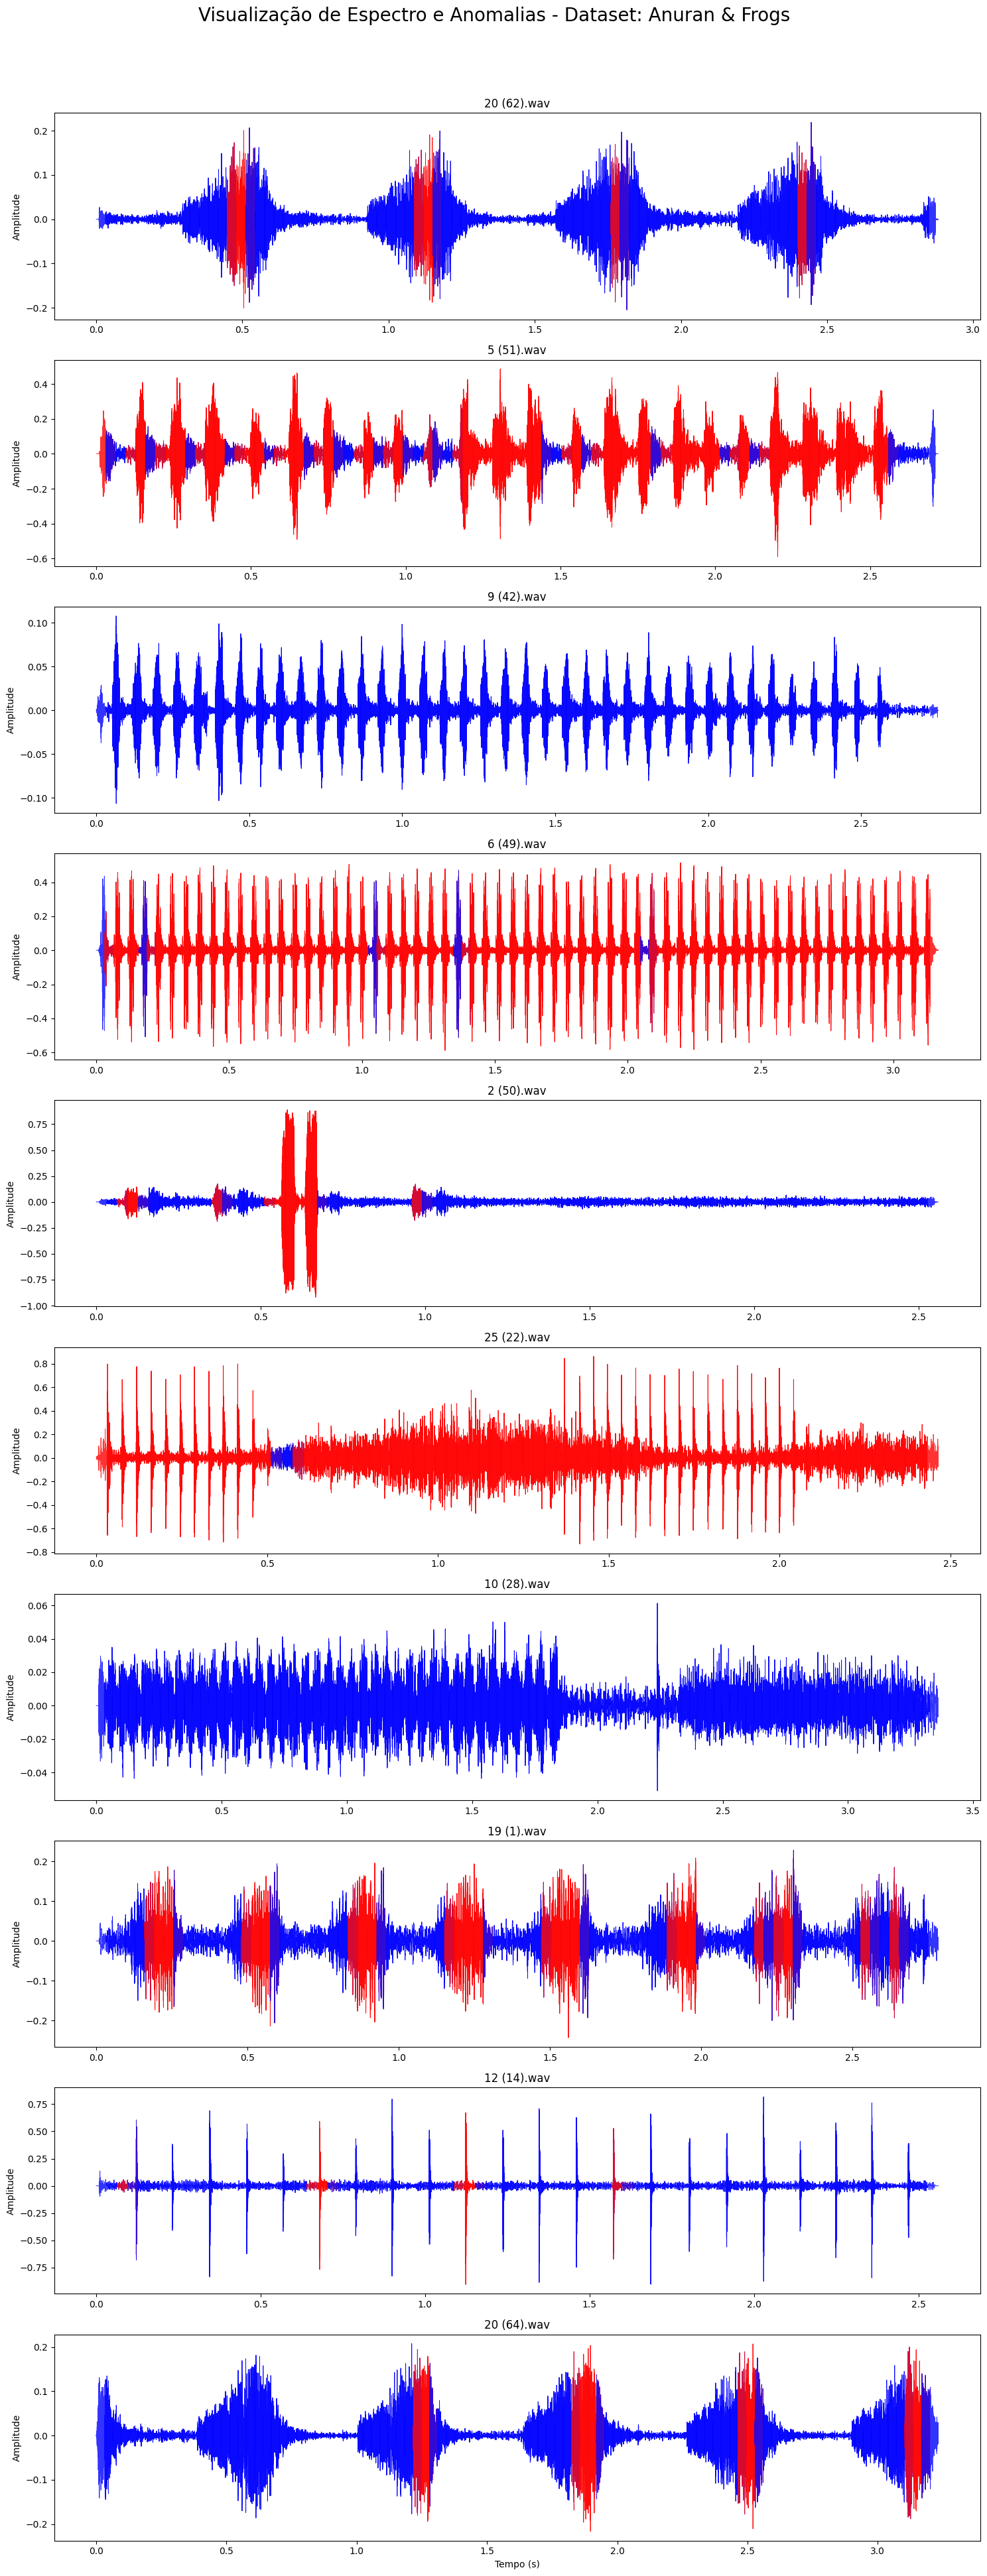



Processando Dataset: Sons Ambientais Selecionados
Analisando 10 áudios de 'Sons Ambientais Selecionados'...


Processando áudios de Sons Ambientais Selecionados:   0%|          | 0/10 [00:00<?, ?it/s]


Treinando e aplicando Isolation Forest com base nos scores...
Gerando gráficos...


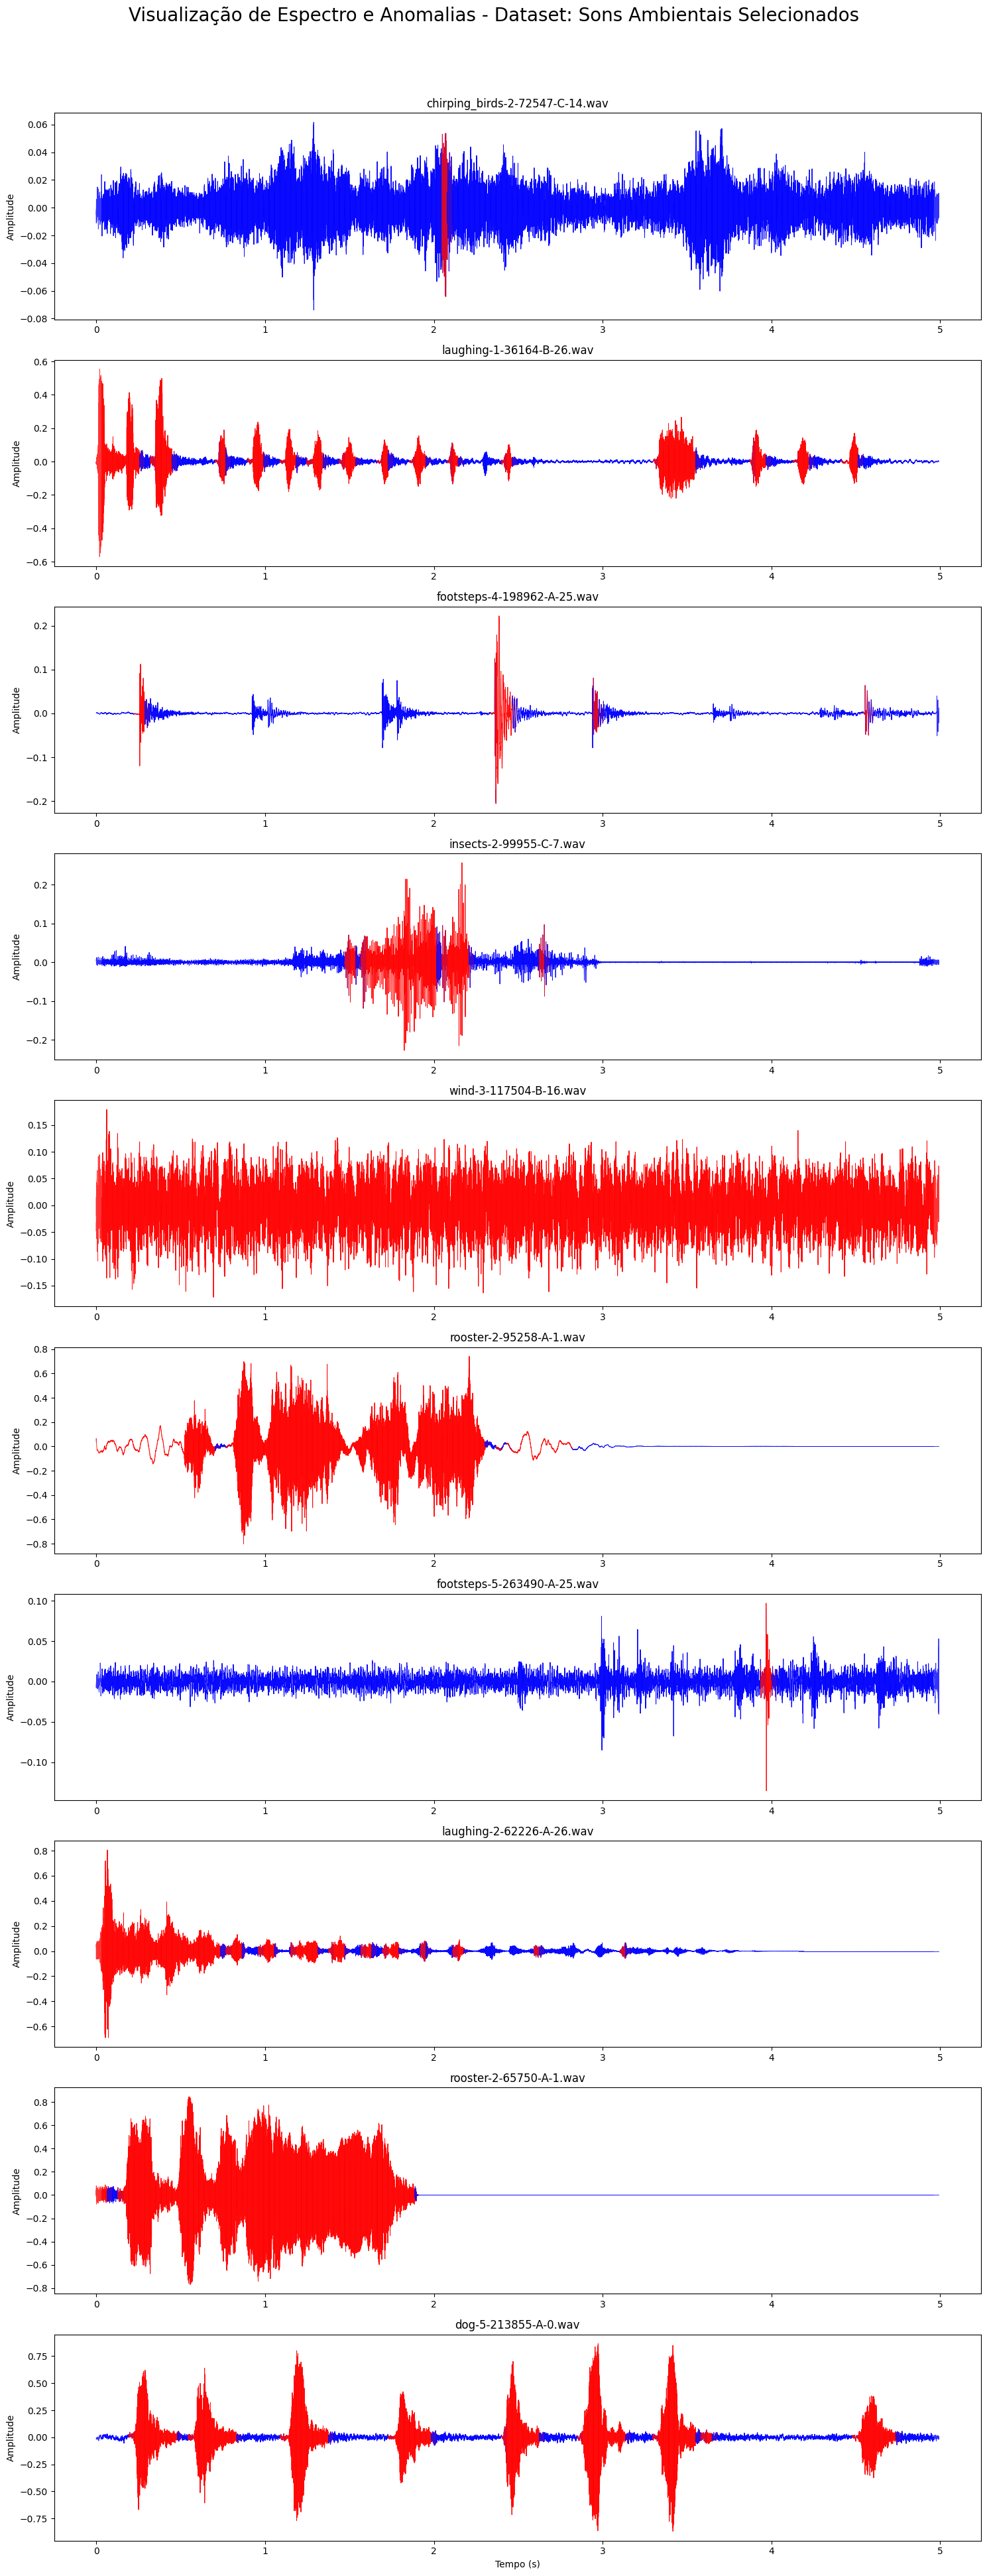

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import Normalizer
import librosa
import librosa.display
from tqdm.auto import tqdm

print("--- ETAPA FINAL: DETECÇÃO DE ANOMALIAS E VISUALIZAÇÃO ---")

# --- PARÂMETROS E CONFIGURAÇÕES ---
# Caminhos dos datasets finais (já definidos nas células anteriores)
FINAL_ANURAN_PATH = "/kaggle/working/resampled_audio/anuran_audio_16khz"
FINAL_AMBIENT_PATH = "/kaggle/working/resampled_audio/ambient_audio_16khz"

# Dicionário para iterar sobre os datasets
datasets_to_process = {
    "Anuran & Frogs": FINAL_ANURAN_PATH,
    "Sons Ambientais Selecionados": FINAL_AMBIENT_PATH
}

N_AUDIOS_TO_SAMPLE = 10  # Número de áudios para analisar de cada dataset
FRAME_SIZE = 1024        # Tamanho do quadro (frame) para análise
HOP_LENGTH = 512         # Salto entre os quadros (hop length)

# --- PROCESSAMENTO E VISUALIZAÇÃO ---
for dataset_name, dataset_path in datasets_to_process.items():
    print(f"\n\n=============================================================")
    print(f"Processando Dataset: {dataset_name}")
    print(f"=============================================================")

    # Seleciona 10 áudios aleatórios do diretório
    try:
        all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]
        if len(all_files) >= N_AUDIOS_TO_SAMPLE:
            audio_files_sample = random.sample(all_files, N_AUDIOS_TO_SAMPLE)
        else:
            audio_files_sample = all_files
            print(f"AVISO: Encontrados apenas {len(all_files)} áudios. Processando todos.")

        print(f"Analisando {len(audio_files_sample)} áudios de '{dataset_name}'...")
    except FileNotFoundError:
        print(f"ERRO: Diretório não encontrado: {dataset_path}. Pulando este dataset.")
        continue

    # Estruturas para armazenar os dados processados
    dados_plot = []  # Para armazenar dados para o plot (x, y)
    X_train = []     # Para armazenar os frames para o treinamento do modelo
    audio_names = [] # Para armazenar os nomes dos arquivos para os títulos dos gráficos

    # Processa cada áudio selecionado
    for audio_path in tqdm(audio_files_sample, desc=f"Processando áudios de {dataset_name}"):
        try:
            y, sr = librosa.load(audio_path, sr=None)
            audio_names.append(os.path.basename(audio_path))

            # Utiliza a função 'frame' do librosa para segmentar o áudio
            frames = librosa.util.frame(y, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH, axis=0)
            X_train.extend(frames)

            # Prepara os dados para plotagem, mantendo a estrutura do código de exemplo
            linha_dados = []
            for i, frame in enumerate(frames):
                # O eixo 'x' será o vetor de tempo para cada quadro
                time = np.linspace(i * HOP_LENGTH / sr, (i * HOP_LENGTH + FRAME_SIZE - 1) / sr, FRAME_SIZE)
                linha_dados.append((time, frame))
            dados_plot.append(linha_dados)

        except Exception as e:
            print(f"Erro ao processar o arquivo {os.path.basename(audio_path)}: {e}")
            continue

    if not X_train:
        print(f"Nenhum dado de áudio foi extraído para o dataset {dataset_name}. Pulando para o próximo.")
        continue

    # --- APLICAÇÃO DO MODELO ISOLATION FOREST ---
    print("\nTreinando e aplicando Isolation Forest com base nos scores...")
    model = IsolationForest(contamination=0.32, random_state=42, bootstrap=False)
    model.fit(X_train)
    anomaly_scores = model.decision_function(X_train)

    df = pd.DataFrame(anomaly_scores, columns=["scores"])
    X_scaled = Normalizer().fit_transform(df.values)
    df["scores_norm"] = X_scaled

    scores_norm_mean = df["scores_norm"].mean()
    scores_norm_std = df["scores_norm"].std()

    upper_limit = scores_norm_mean + 1 * scores_norm_std
    bottom_limit = scores_norm_mean - 1 * scores_norm_std

    df["is_anomaly"] = np.where((df["scores_norm"] > upper_limit) | (df["scores_norm"] < bottom_limit), 1, 0)
    ano = df["is_anomaly"].tolist()

    # --- PLOT DOS RESULTADOS ---
    print("Gerando gráficos...")
    fig, ax = plt.subplots(len(dados_plot), 1, figsize=(15, 4 * len(dados_plot)))

    # Caso especial para apenas 1 áudio
    if len(dados_plot) == 1:
        ax = [ax]

    fig.suptitle(f"Visualização de Espectro e Anomalias - Dataset: {dataset_name}", fontsize=20, y=1.0)

    frame_counter = 0
    for i, linha in enumerate(dados_plot):
        ax[i].set_title(audio_names[i], fontsize=12)

        # Plot dos espectros com anomalias destacadas
        for x, y in linha:
            ax[i].plot(x, y, color='red' if ano[frame_counter] else 'blue', alpha=0.8, linewidth=0.7)
            frame_counter += 1

        ax[i].set_ylabel("Amplitude")
        if i == len(dados_plot) - 1: # Adiciona label de tempo apenas no último gráfico
            ax[i].set_xlabel("Tempo (s)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

## Aplicação de Outra Técnica Para Identificar Pontos de Interesse do Audio - Análise espectro

--- NOVA ABORDAGEM: EXTRAÇÃO DE SEGMENTOS BASEADA EM PICOS COM VISUALIZAÇÃO E REPRODUÇÃO ---


Processando Dataset: Anuran & Frogs
Analisando 5 áudios de 'Anuran & Frogs'...


Processando áudios:   0%|          | 0/5 [00:00<?, ?it/s]


------------------
Analisando: 16 (57).wav


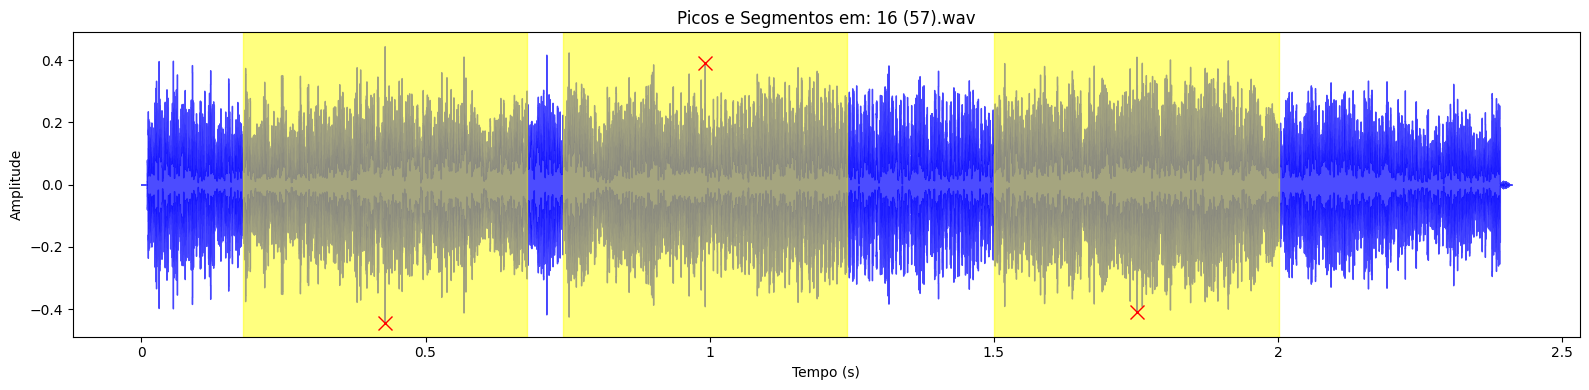

Áudio original para reprodução:



------------------
Analisando: 8 (11).wav


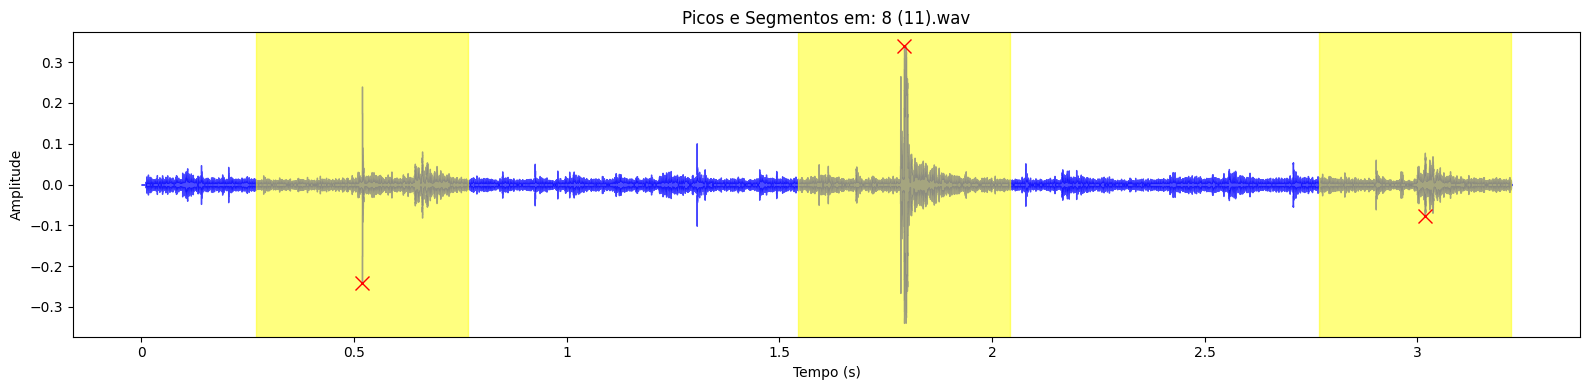

Áudio original para reprodução:



------------------
Analisando: 2 (40).wav


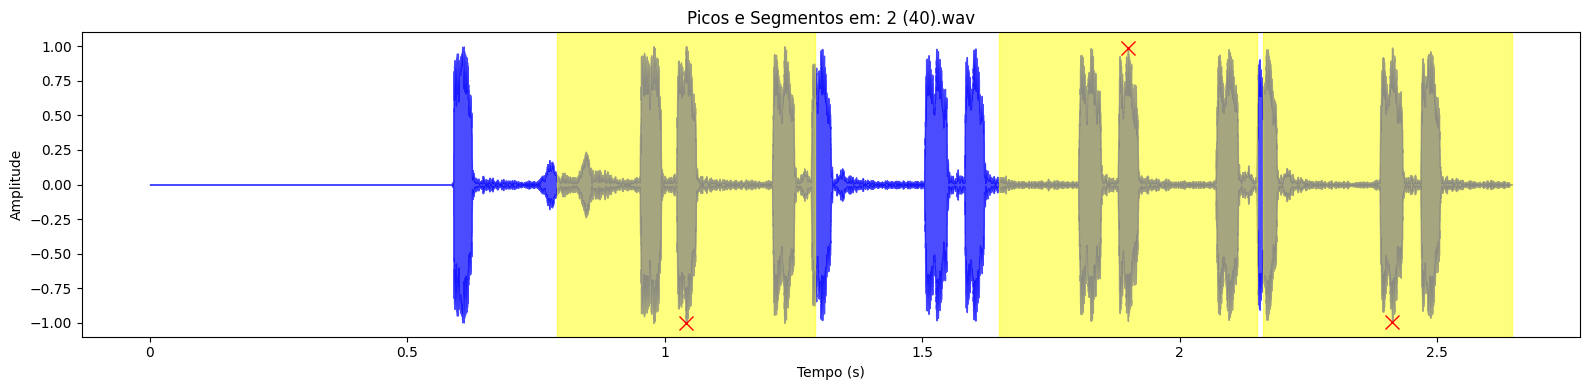

Áudio original para reprodução:



------------------
Analisando: 8 (20).wav


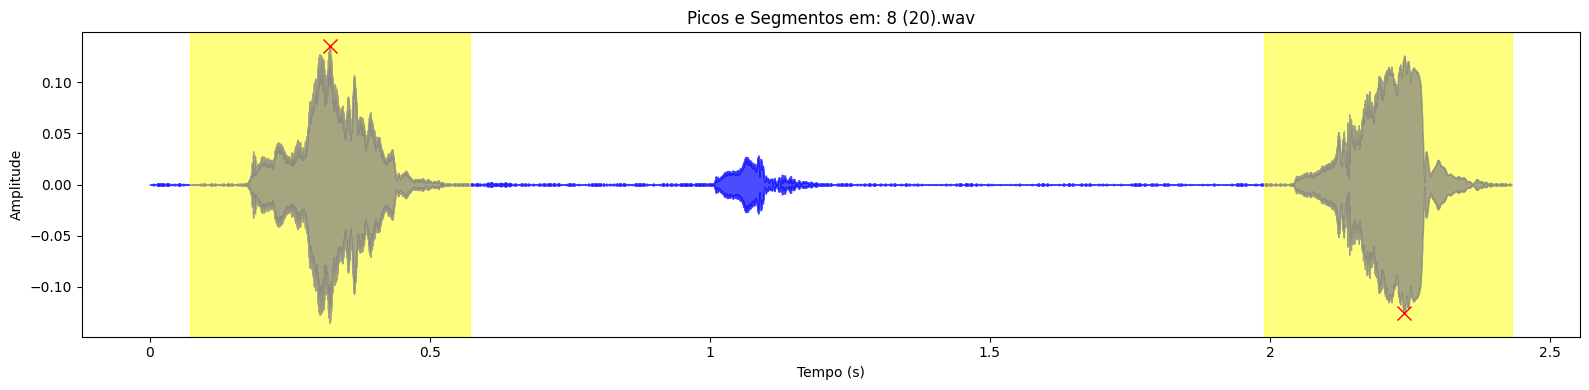

Áudio original para reprodução:



------------------
Analisando: 21 (42).wav


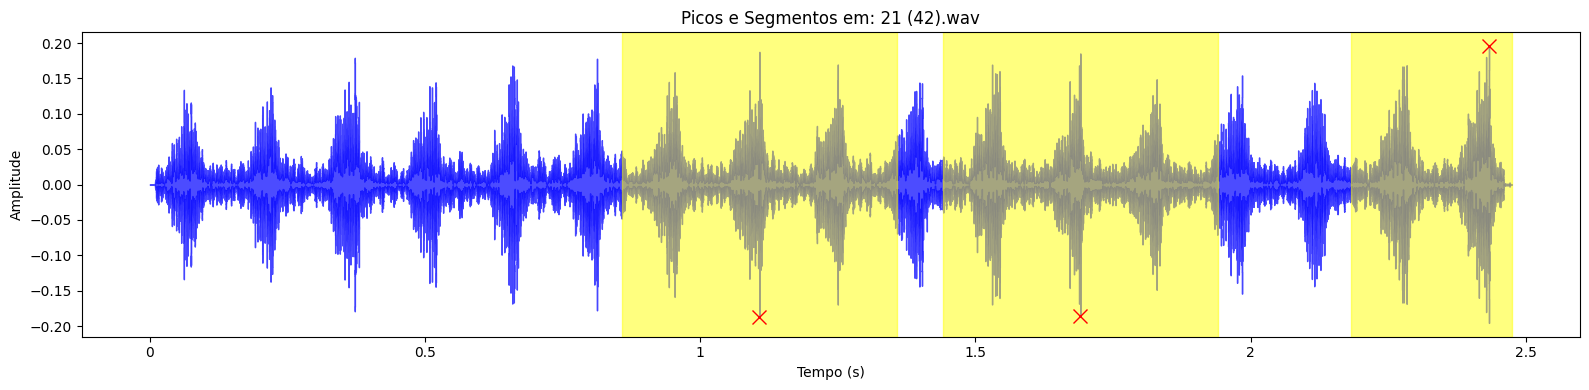

Áudio original para reprodução:




Processando Dataset: Sons Ambientais Selecionados
Analisando 5 áudios de 'Sons Ambientais Selecionados'...


Processando áudios:   0%|          | 0/5 [00:00<?, ?it/s]


------------------
Analisando: pouring_water-4-186693-A-17.wav


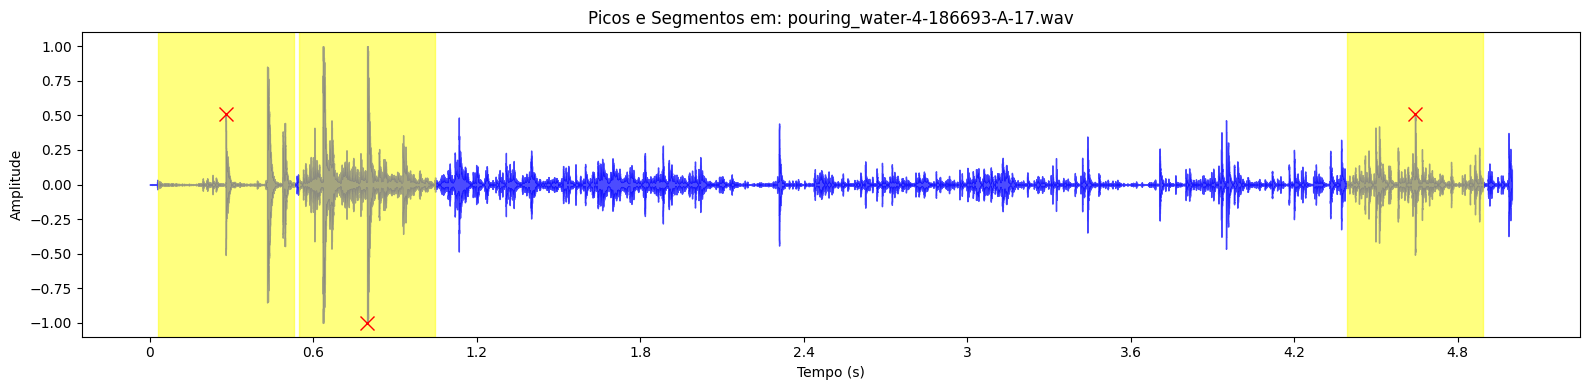

Áudio original para reprodução:



------------------
Analisando: hen-4-200330-A-6.wav


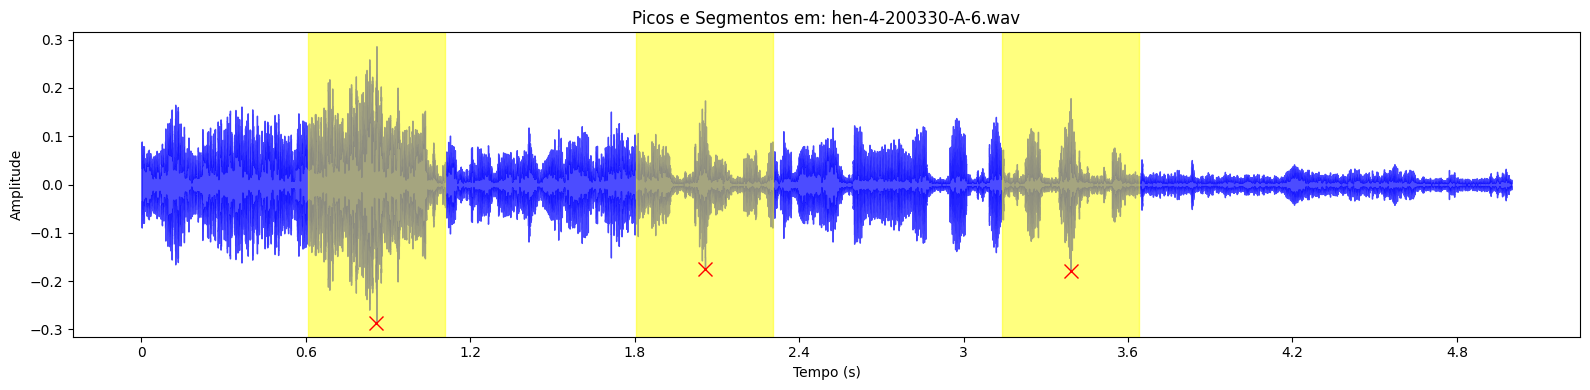

Áudio original para reprodução:



------------------
Analisando: crow-4-173865-A-9.wav


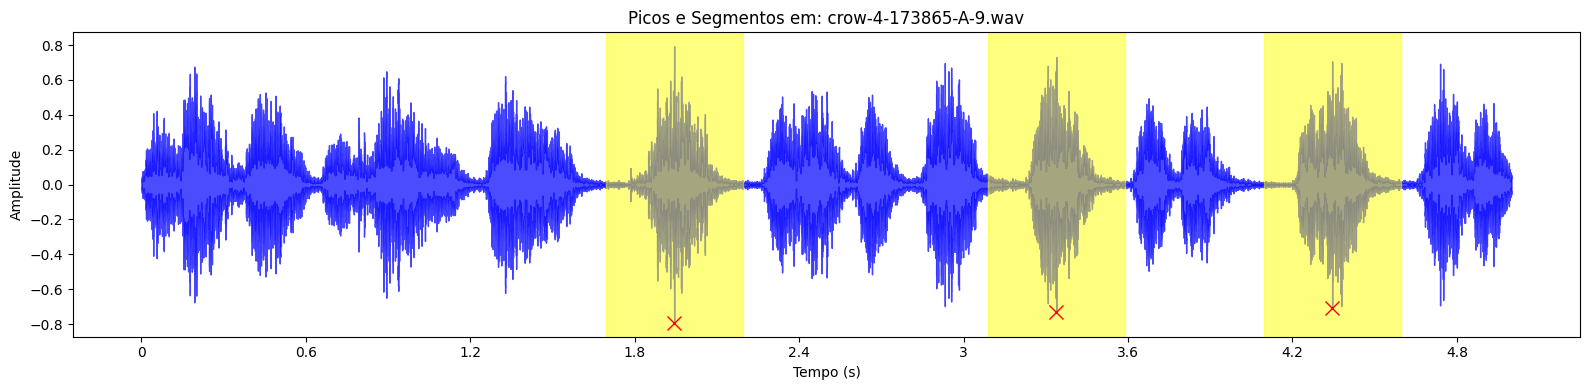

Áudio original para reprodução:



------------------
Analisando: insects-2-81970-A-7.wav


Áudio original para reprodução:



------------------
Analisando: thunderstorm-3-103051-C-19.wav


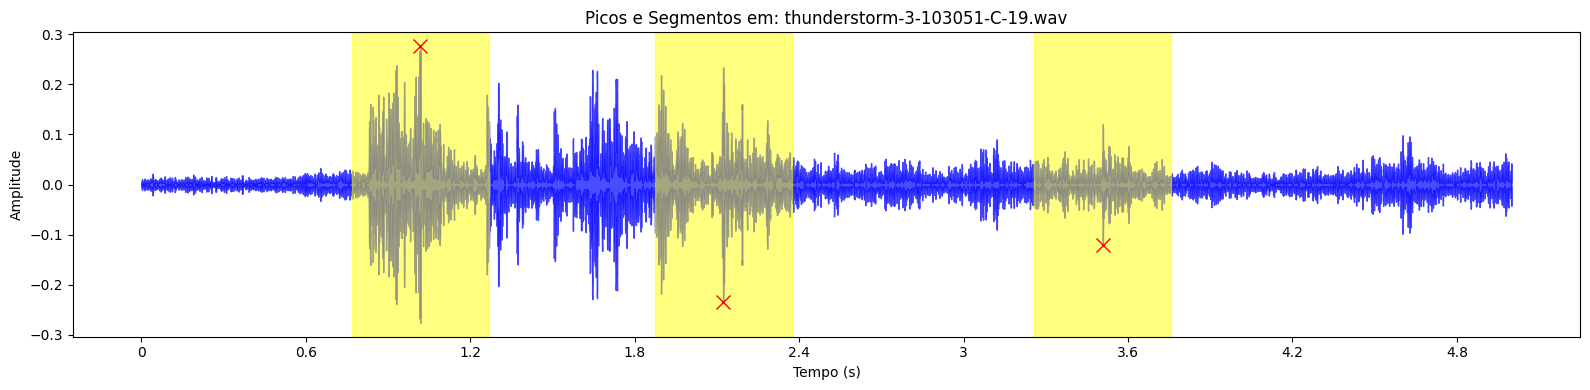

Áudio original para reprodução:


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.signal
import librosa
import librosa.display
import soundfile as sf
from tqdm.auto import tqdm
from IPython.display import display, Audio

print("--- NOVA ABORDAGEM: EXTRAÇÃO DE SEGMENTOS BASEADA EM PICOS COM VISUALIZAÇÃO E REPRODUÇÃO ---")

FINAL_ANURAN_PATH = "/kaggle/working/resampled_audio/anuran_audio_16khz"
FINAL_AMBIENT_PATH = "/kaggle/working/resampled_audio/ambient_audio_16khz"
OUTPUT_DIR_PEAKS = "/kaggle/working/resampled_audio/peak_clips" # Desativado

datasets_to_process = {
    "Anuran_&_Frogs": FINAL_ANURAN_PATH,
    "Sons_Ambientais_Selecionados": FINAL_AMBIENT_PATH
}

N_AUDIOS_TO_SAMPLE = 5
N_PEAKS = 3
CLIP_DURATION_MS = 500

# --- PROCESSAMENTO E VISUALIZAÇÃO ---
for dataset_name, dataset_path in datasets_to_process.items():
    print(f"\n\n=============================================================")
    print(f"Processando Dataset: {dataset_name.replace('_', ' ')}")
    print(f"=============================================================")

    # Cria subdiretório para os clipes deste dataset (se a seção de salvar for reativada)
    # save_path_dataset = os.path.join(OUTPUT_DIR_PEAKS, dataset_name)
    # os.makedirs(save_path_dataset, exist_ok=True)

    # Seleciona 10 áudios aleatórios do diretório
    try:
        all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]
        if len(all_files) >= N_AUDIOS_TO_SAMPLE:
            audio_files_sample = random.sample(all_files, N_AUDIOS_TO_SAMPLE)
        else:
            audio_files_sample = all_files
            print(f"AVISO: Encontrados apenas {len(all_files)} áudios. Processando todos.")

        print(f"Analisando {len(audio_files_sample)} áudios de '{dataset_name.replace('_', ' ')}'...")
    except FileNotFoundError:
        print(f"ERRO: Diretório não encontrado: {dataset_path}. Pulando.")
        continue

    # Processa e plota cada áudio individualmente
    for audio_path in tqdm(audio_files_sample, desc=f"Processando áudios"):
        try:
            y, sr = librosa.load(audio_path, sr=None)
            audio_name = os.path.basename(audio_path)

            print(f"\n------------------\nAnalisando: {audio_name}")

            # --- Detecção de Picos ---
            peaks, _ = scipy.signal.find_peaks(np.abs(y), distance=int(sr * 0.5), prominence=0.05)

            # Cria a figura para o gráfico
            fig, ax = plt.subplots(1, 1, figsize=(16, 4))

            # Plota a forma de onda
            librosa.display.waveshow(y, sr=sr, ax=ax, alpha=0.7, color='blue')
            ax.set_title(f"Picos e Segmentos em: {audio_name}")
            ax.set_xlabel("Tempo (s)")
            ax.set_ylabel("Amplitude")

            if peaks.size > 0:
                # Ordena os picos pela sua amplitude para encontrar os mais proeminentes
                sorted_peak_indices = np.argsort(np.abs(y[peaks]))[::-1]
                top_peaks = peaks[sorted_peak_indices[:N_PEAKS]]
                top_peaks.sort() # Ordena por tempo para plotar corretamente

                # --- Extração e Destaque dos Segmentos ---
                half_window_samples = int((CLIP_DURATION_MS / 2 / 1000) * sr)

                for j, peak_index in enumerate(top_peaks):
                    # Marca o pico no gráfico
                    peak_time = librosa.samples_to_time(peak_index, sr=sr)
                    ax.plot(peak_time, y[peak_index], 'rx', markersize=10)

                    # Calcula o início e o fim do segmento de 500ms
                    start_sample = max(0, peak_index - half_window_samples)
                    end_sample = min(len(y), peak_index + half_window_samples)

                    # Destaca a área no gráfico
                    start_time = librosa.samples_to_time(start_sample, sr=sr)
                    end_time = librosa.samples_to_time(end_sample, sr=sr)
                    ax.axvspan(start_time, end_time, color='yellow', alpha=0.5)
            else:
                 ax.text(0.5, 0.5, 'Nenhum pico proeminente detectado', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

            # Exibe o gráfico e o player de áudio
            plt.tight_layout()
            plt.show()

            print("Áudio original para reprodução:")
            display(Audio(data=y, rate=sr))

        except Exception as e:
            print(f"Erro ao processar o arquivo {audio_name}: {e}")

## Seleção das amostras

Para essa etapa, serão retiradas 5 amostras de cada áudio ambiente (nosso limitador), obtendo assim 3200 amostras de 0.5s cada para essa classe. A mesma quantidade de amostras será retirada dos sons dos sapos, de forma com que cada áudio tenha pelo menos 2 amostras e alguns tenham 3, obtendo também 3200 amostras no final

In [ ]:
# Célula Final: Geração dos Datasets de Amostras de Áudio

import os
import numpy as np
import scipy.signal
import librosa
import soundfile as sf
from tqdm.auto import tqdm
import random

print("--- ETAPA FINAL: GERANDO DATASETS DE AMOSTRAS DE ÁUDIO ---")

# --- PARÂMETROS E CONFIGURAÇÕES ---
# Caminhos dos datasets de origem
FINAL_ANURAN_PATH = "/kaggle/working/resampled_audio/anuran_audio_16khz"
FINAL_AMBIENT_PATH = "/kaggle/working/resampled_audio/ambient_audio_16khz"

# Caminhos dos diretórios de destino
FROG_SAMPLES_DIR = "/kaggle/working/resampled_audio/frog_final_samples"
AMBIENT_SAMPLES_DIR = "/kaggle/working/resampled_audio/ambient_final_samples"

# Parâmetros de extração
CLIP_DURATION_MS = 500
TARGET_SAMPLE_COUNT = 3200

# Cria os diretórios de destino
os.makedirs(FROG_SAMPLES_DIR, exist_ok=True)
os.makedirs(AMBIENT_SAMPLES_DIR, exist_ok=True)
print(f"Diretório para amostras de sapos criado: {FROG_SAMPLES_DIR}")
print(f"Diretório para amostras de ambiente criado: {AMBIENT_SAMPLES_DIR}")

# --- FUNÇÃO AUXILIAR PARA EXTRAÇÃO ---

def extract_and_save_peaks(audio_path, output_dir, n_peaks, sr=16000, duration_ms=500):
    """
    Carrega um áudio, encontra um número 'n_peaks' de picos,
    extrai segmentos e os salva no diretório de saída.
    """
    try:
        y, sr_loaded = librosa.load(audio_path, sr=sr)
        audio_name = os.path.basename(audio_path)

        # Encontra picos com distância e proeminência mínimas para garantir relevância
        peaks, _ = scipy.signal.find_peaks(np.abs(y), distance=int(sr * 0.25), prominence=0.02)

        if peaks.size == 0:
            return 0 # Nenhum pico encontrado

        # Ordena picos pela amplitude e seleciona os 'n_peaks' mais proeminentes
        sorted_peak_indices = np.argsort(np.abs(y[peaks]))[::-1]
        top_peaks = peaks[sorted_peak_indices[:n_peaks]]

        half_window_samples = int((duration_ms / 2 / 1000) * sr)

        saved_count = 0
        for i, peak_index in enumerate(top_peaks):
            start_sample = max(0, peak_index - half_window_samples)
            end_sample = min(len(y), peak_index + half_window_samples)

            segment = y[start_sample:end_sample]

            # Garante que o clipe tenha a duração exata, preenchendo com silêncio se estiver nas bordas
            if len(segment) < (2 * half_window_samples):
                segment = np.pad(segment, (0, (2 * half_window_samples) - len(segment)), 'constant')

            clip_filename = f"peak{i+1}_{audio_name}"
            clip_path = os.path.join(output_dir, clip_filename)
            sf.write(clip_path, segment, sr)
            saved_count += 1

        return saved_count

    except Exception as e:
        print(f"Erro ao processar {audio_path}: {e}")
        return 0

# --- 1. PROCESSAR SONS AMBIENTAIS ---
print("\n--- Processando Dataset de Sons Ambientais ---")
ambient_files = [os.path.join(FINAL_AMBIENT_PATH, f) for f in os.listdir(FINAL_AMBIENT_PATH) if f.endswith('.wav')]
ambient_clips_total = 0
for audio_file in tqdm(ambient_files, desc="Extraindo amostras de ambiente"):
    # Extrai 5 picos por arquivo ou quantos forem possíveis
    ambient_clips_total += extract_and_save_peaks(audio_file, AMBIENT_SAMPLES_DIR, n_peaks=5)

print(f"Concluído! Total de amostras de ambiente extraídas: {ambient_clips_total}")


# --- 2. PROCESSAR SONS DE SAPOS E ANUROS ---
print("\n--- Processando Dataset de Sapos e Anuros ---")
anuran_files = [os.path.join(FINAL_ANURAN_PATH, f) for f in os.listdir(FINAL_ANURAN_PATH) if f.endswith('.wav')]
num_anuran_audios = len(anuran_files)

# Calcula a distribuição de amostras para atingir o objetivo de 3200
base_samples = 2
remaining_samples = TARGET_SAMPLE_COUNT - (num_anuran_audios * base_samples)

# Cria uma lista indicando quantos clipes extrair de cada áudio
samples_per_audio = [base_samples] * num_anuran_audios
if remaining_samples > 0:
    for i in range(remaining_samples):
        samples_per_audio[i % num_anuran_audios] += 1
random.shuffle(samples_per_audio) # Embaralha para que a extração de 3 picos seja aleatória entre os áudios

print(f"Para atingir a meta de ~{TARGET_SAMPLE_COUNT} amostras:")
print(f"- {samples_per_audio.count(2)} áudios terão 2 amostras extraídas.")
print(f"- {samples_per_audio.count(3)} áudios terão 3 amostras extraídas.")

anuran_clips_total = 0
for i, audio_file in enumerate(tqdm(anuran_files, desc="Extraindo amostras de sapos")):
    n_peaks_to_extract = samples_per_audio[i]
    anuran_clips_total += extract_and_save_peaks(audio_file, FROG_SAMPLES_DIR, n_peaks=n_peaks_to_extract)

print(f"Concluído! Total de amostras de sapos e anuros extraídas: {anuran_clips_total}")

print("\n\n--- GERAÇÃO DE DATASETS CONCLUÍDA ---")

--- ETAPA FINAL: GERANDO DATASETS DE AMOSTRAS DE ÁUDIO ---
Diretório para amostras de sapos criado: /kaggle/working/resampled_audio/frog_final_samples
Diretório para amostras de ambiente criado: /kaggle/working/resampled_audio/ambient_final_samples

--- Processando Dataset de Sons Ambientais ---


Extraindo amostras de ambiente:   0%|          | 0/640 [00:00<?, ?it/s]

Concluído! Total de amostras de ambiente extraídas: 3083

--- Processando Dataset de Sapos e Anuros ---
Para atingir a meta de ~3200 amostras:
- 1408 áudios terão 2 amostras extraídas.
- 128 áudios terão 3 amostras extraídas.


Extraindo amostras de sapos:   0%|          | 0/1536 [00:00<?, ?it/s]

Concluído! Total de amostras de sapos e anuros extraídas: 3162


--- GERAÇÃO DE DATASETS CONCLUÍDA ---


In [ ]:
# Célula de Análise: Sumarizando os Datasets de Amostras Finais

import os
import pandas as pd
import librosa
from tqdm.auto import tqdm
from IPython.display import display
import warnings

# Ignora avisos que podem ocorrer durante a leitura de múltiplos arquivos
warnings.filterwarnings('ignore')

print("--- ANÁLISE DOS DATASETS DE AMOSTRAS FINAIS ---")

# --- PARÂMETROS E CONFIGURAÇÕES ---
FROG_SAMPLES_DIR = "/kaggle/working/resampled_audio/frog_final_samples"
AMBIENT_SAMPLES_DIR = "/kaggle/working/resampled_audio/ambient_final_samples"

# --- FUNÇÃO DE ANÁLISE DE DIRETÓRIO ---

def analyze_final_folders(folder_path, dataset_name):
    """
    Analisa um diretório de áudios e extrai métricas chave, tratando
    todos os arquivos no diretório como uma única classe.
    """
    if not os.path.isdir(folder_path):
        print(f"AVISO: O diretório '{folder_path}' não foi encontrado. Retornando dados vazios.")
        return {}

    audio_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.wav')]
    if not audio_files:
        print(f"AVISO: Nenhum arquivo .wav encontrado em '{folder_path}'.")
        return {}

    durations = []
    sample_rates = set()
    file_sizes_bytes = []

    # Itera sobre os arquivos com uma barra de progresso
    for filename in tqdm(audio_files, desc=f"Analisando '{dataset_name}'"):
        file_path = os.path.join(folder_path, filename)
        try:
            # Coleta o tamanho do arquivo
            file_sizes_bytes.append(os.path.getsize(file_path))

            # Carrega o áudio para obter duração e taxa de amostragem
            y, sr = librosa.load(file_path, sr=None)
            durations.append(librosa.get_duration(y=y, sr=sr))
            sample_rates.add(sr)

        except Exception as e:
            print(f"Erro ao processar o arquivo {filename}: {e}")

    # Compila os resultados em um dicionário
    summary = {
        "Dataset": dataset_name,
        "Total de Amostras": len(audio_files),
        "Taxa de Amostragem (Hz)": ", ".join(map(str, sorted(list(sample_rates)))),
        "Duração Total (min)": f"{(sum(durations) / 60):.2f}",
        "Duração Média (s)": f"{np.mean(durations):.2f}",
        "Tamanho Total (GB)": f"{(sum(file_sizes_bytes) / (1024**3)):.2f}",
        "Tamanho Médio (MB)": f"{(np.mean(file_sizes_bytes) / (1024**2)):.2f}"
    }
    return summary

# --- EXECUÇÃO DA ANÁLISE E EXIBIÇÃO DA TABELA ---

# Lista de datasets para analisar
datasets_to_analyze = [
    {"name": "Amostras Finais de Sapos", "path": FROG_SAMPLES_DIR},
    {"name": "Amostras Finais de Ambiente", "path": AMBIENT_SAMPLES_DIR}
]

summary_list = []
for dataset in datasets_to_analyze:
    folder_summary = analyze_final_folders(dataset["path"], dataset["name"])
    if folder_summary:
        summary_list.append(folder_summary)

if summary_list:
    # Cria e exibe o DataFrame do pandas
    df_final_summary = pd.DataFrame(summary_list)
    df_final_summary.set_index("Dataset", inplace=True)

    print("\n\n" + "="*80)
    print("--- TABELA DE RESUMO DOS DATASETS GERADOS ---")
    print("="*80)
    display(df_final_summary)
else:
    print("\nNão foi possível gerar o relatório. Verifique se os diretórios foram criados corretamente.")

--- ANÁLISE DOS DATASETS DE AMOSTRAS FINAIS ---


Analisando 'Amostras Finais de Sapos':   0%|          | 0/3162 [00:00<?, ?it/s]

Analisando 'Amostras Finais de Ambiente':   0%|          | 0/3083 [00:00<?, ?it/s]



--- TABELA DE RESUMO DOS DATASETS GERADOS ---


Total de Amostras Taxa de Amostragem (Hz)  \
Dataset                                                                  
Amostras Finais de Sapos                  3162                   16000   
Amostras Finais de Ambiente               3083                   16000   

                            Duração Total (min) Duração Média (s)  \
Dataset                                                             
Amostras Finais de Sapos                  26.35              0.50   
Amostras Finais de Ambiente               25.69              0.50   

                            Tamanho Total (GB) Tamanho Médio (MB)  
Dataset                                                            
Amostras Finais de Sapos                  0.05               0.02  
Amostras Finais de Ambiente               0.05               0.02

In [ ]:
!zip -r /content/amostras_sapos.zip /kaggle/working/resampled_audio/frog_final_samples
!zip -r /content/amostras_ambiente.zip /kaggle/working/resampled_audio/ambient_final_samples

A saída de streaming foi truncada nas últimas 5000 linhas.
  adding: kaggle/working/resampled_audio/frog_final_samples/peak1_23 (37).wav (deflated 4%)
  adding: kaggle/working/resampled_audio/frog_final_samples/peak1_10 (23).wav (deflated 18%)
  adding: kaggle/working/resampled_audio/frog_final_samples/peak2_7 (18).wav (deflated 11%)
  adding: kaggle/working/resampled_audio/frog_final_samples/peak1_13 (50).wav (deflated 10%)
  adding: kaggle/working/resampled_audio/frog_final_samples/peak3_11 (2).wav (deflated 35%)
  adding: kaggle/working/resampled_audio/frog_final_samples/peak1_5 (50).wav (deflated 30%)
  adding: kaggle/working/resampled_audio/frog_final_samples/peak2_22 (40).wav (deflated 6%)
  adding: kaggle/working/resampled_audio/frog_final_samples/peak2_1 (60).wav (deflated 7%)
  adding: kaggle/working/resampled_audio/frog_final_samples/peak2_20 (25).wav (deflated 15%)
  adding: kaggle/working/resampled_audio/frog_final_samples/peak2_1 (82).wav (deflated 12%)
  adding: kaggle/wo